# Autoencoder (AE)

Путь к Bert начинается с цифирек в MNIST

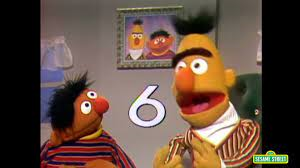

# <font color='green'>0. Импорт необходимых модулей</font>  

Известные стандартные пакеты

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

Для работы с нейронками потребуется ряд пакетов PyTorch https://pytorch.org

In [ ]:
# Для создания и обучения нейронных сетей
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# Для загрузки датасетов
from torch.utils.data import Dataset, DataLoader 

# Для обработки данных
import torchvision
import torchvision.transforms as TF 
from torchvision.utils import make_grid # Для вывода набора изображений

Нейронки обучаются на каком-то устройстве (**device**): 

*   Это либо CPU ("cpu"), 
*   либо GPU ("cuda"). 



Пока можно считать это "magic spell". 

GPU - мощнее. Если дают - надо брать.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Если хочется больше мощи и на порядок большей скорости обучения модели) 

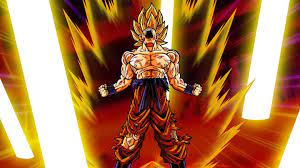

Перейти на GPU можно в **Runtime -> Change runtime type**

###  <font color='red'>В базовой версии Google Colab время GPU в день ограничено. </font> 

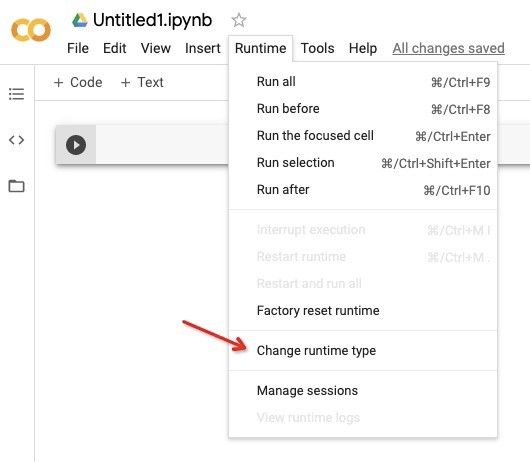

# <font color='green'>1. Нейронные сети (PyTorch) </font>  

**Нейронная сеть** - это вычислительный граф, веса которого обучаются градиентным спуском.

Простейший пример - логистическая регрессия.

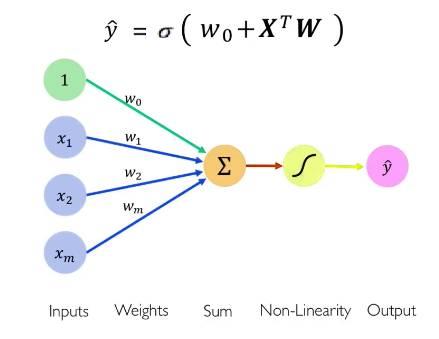

Это композиция двух отображений: 

1.   Аффинного преобразования $$ Z = w^T X + w_0 $$

2.   И сигмоиды $$\hat{y} = \sigma (Z)$$

У первого отображения есть **веса** $w_0, w_1, \dots, w_m$. 

Их мы определяем <font color='blue'>градиентным спуском </font>: 

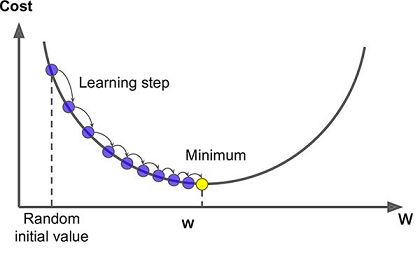


*   Есть **функция потерь** $L$, которую мы стремимся минимизировать $$L(X, w) \to \min.$$ Например, этом может быть кросс-энтропия или MSE-loss $$MSE = \frac{1}{n} \sum_i \left\|y_i - \hat{y}_i(X^{(i)}, w) \right\|^2.$$



*   В процессе *обучения* мы подаём нейронке на вход набор объектов $X = (X^{(1)}, \dots, X^{(N)})$, вычисляем $L = L(X, w)$ и **обновляем веса в сторону противоположную градиенту функции потерь** (если ищем минимум) $$ w_j \to w_j - \alpha \frac{\partial}{\partial w_j} L.$$


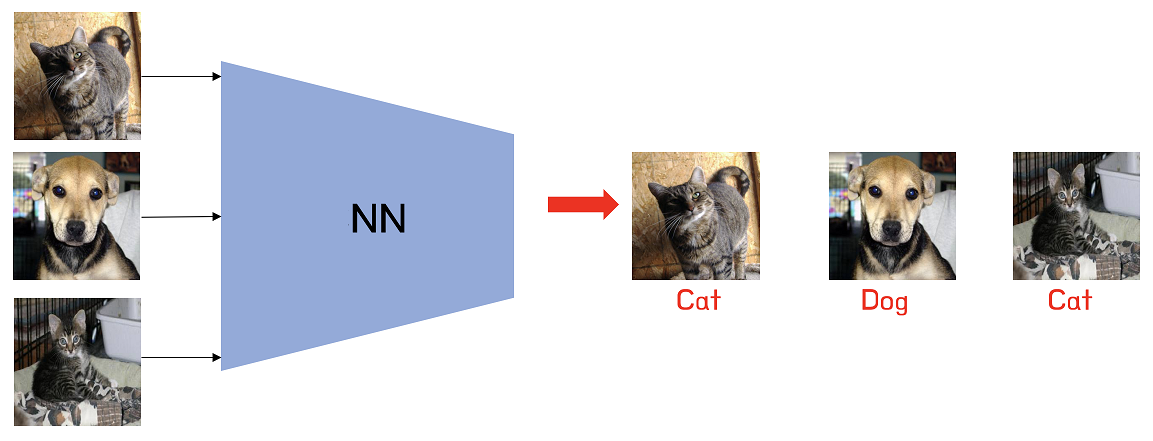

Большие нейронки - композиции большого числа разных отображений. В целом логика та же. 


Например, нейронке, отличающей котика от пёсика, мы будем много раз давать посмотреть на N котиков\пёсиков, и каждый раз она будет обновлять веса вдоль новых градиентов. 

Все базовые операции уже реализованы за наc в https://pytorch.org

## <font color='green'>1.1 Тензоры Torch </font>  

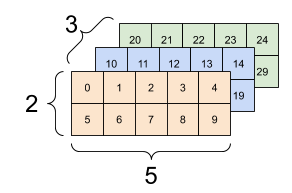

На входе и выходе у нейронных сетей - **тензоры** (многомерные массивы).

https://pytorch.org/docs/stable/tensors.html

Создадим нулевой массив (2, 4)

In [ ]:
m1 = torch.zeros([2, 4], dtype=torch.int32) 
m1

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int32)

Знакомый интерфейс? 

#  <font color='blue'> PyTorch - это Numpy с градиентами </font>

Numpy и Torch можно перегонять друг в друга

In [ ]:
n1 = m1.numpy()
print(type(n1))
print(n1)

<class 'numpy.ndarray'>
[[0 0 0 0]
 [0 0 0 0]]


Иногда тензору нужно забыть градиенты. Для этого есть команда **detach**

In [ ]:
n1 = m1.detach().numpy()
print(type(n1))
print(n1)

<class 'numpy.ndarray'>
[[0 0 0 0]
 [0 0 0 0]]


Numpy -> Torch

In [ ]:
m2 = torch.from_numpy(n1)
print(type(m2))
print(m2)

<class 'torch.Tensor'>
tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int32)


## <font color='green'>1.2 Стандратные блоки </font>

https://pytorch.org/docs/stable/nn.html

Мы рассмотрим линейное отображение 

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

In [ ]:
lin = nn.Linear(20, 30)
lin.weight.shape, lin.bias.shape #веса и bias

(torch.Size([30, 20]), torch.Size([30]))

Слой $Linear(H_{in}, H_{out})$ отображает следующим образом меняет размер тензора: $$(N, H_{in}) \to (N, H_{out})$$

In [ ]:
input = torch.randn(128, 20)
output = lin(input)
print(output.size())

torch.Size([128, 30])


###  Всегда <font color='red'> 1ая размерность  N - размер батча </font>

Если мы хотим получить Логистическую Регрессию, то нужно добавить Сигмоиду

In [ ]:
lin = nn.Linear(20, 1)
act = nn.Sigmoid()

Логистическая регрессия "a la  PyTorch"

In [ ]:
input = torch.randn(128, 20)
output = act(lin(input))
print(output.size())

torch.Size([128, 1])


### <font color='green'>1.2.1 Проверим, что мы действительно получаем Logistic Regression</font>

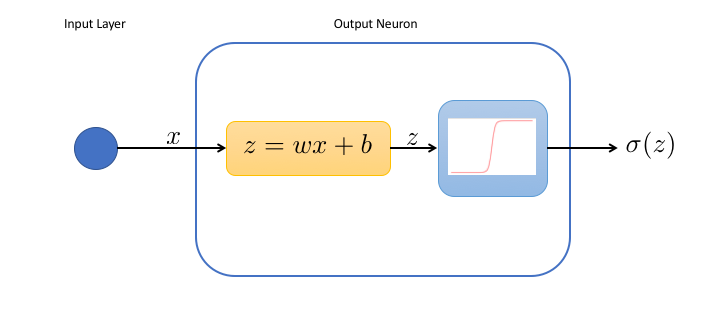

In [ ]:
from sklearn.linear_model import LogisticRegression

Делаем коэффициенты равными

In [ ]:
logreg = LogisticRegression()
logreg.coef_, logreg.intercept_ = lin.weight.detach().numpy(), lin.bias.detach().numpy()
logreg.classes_ = np.array([-1, 1])

Проверяем, что функции дают один и тот же ответ

In [ ]:
input = torch.randn(128, 20) # Случайный тензор 128x20 = 128 векторов в 20-D

# LogReg
np_input = [input.numpy()[i,:] for i in range(128)] # Делаем 2D массива список 1D векторов
np_pred =  np.array([logreg.predict_proba(x.reshape(1,-1))[0,1] for x in np_input]) # Numpy предсказание
assert np_pred.shape == (128,)

# PyTorch
torch_pred = act(lin(input)).detach().numpy()[:,0]
assert torch_pred.shape == (128,)

# Ответы совпали
assert np.allclose(np_pred, torch_pred)

## <font color='green'>1.2.2 Convolution layers</font>

Обычно лучше учитывать <font color='red'>структуру данных</font>. \

Для изображений естественно рассматривать свойства **инвариантные относительно сдвигов**.

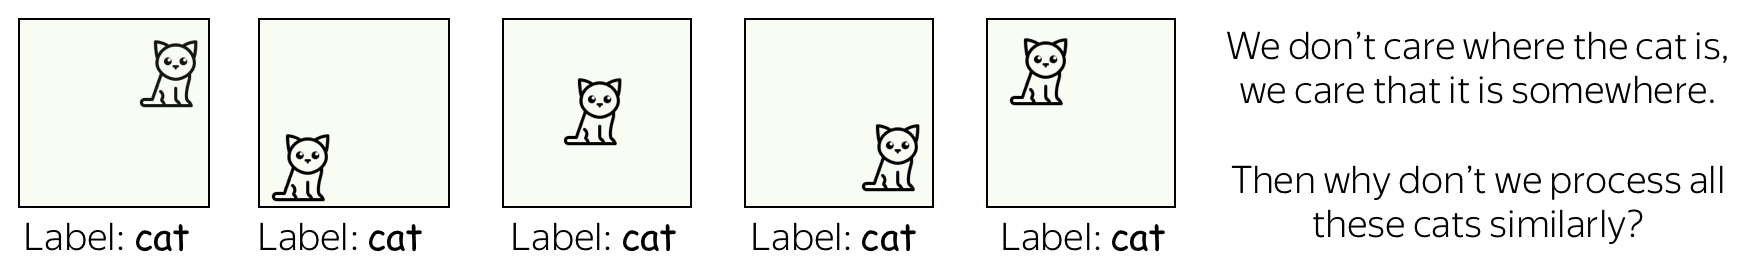

Так возникает идея использовать свёртки. 

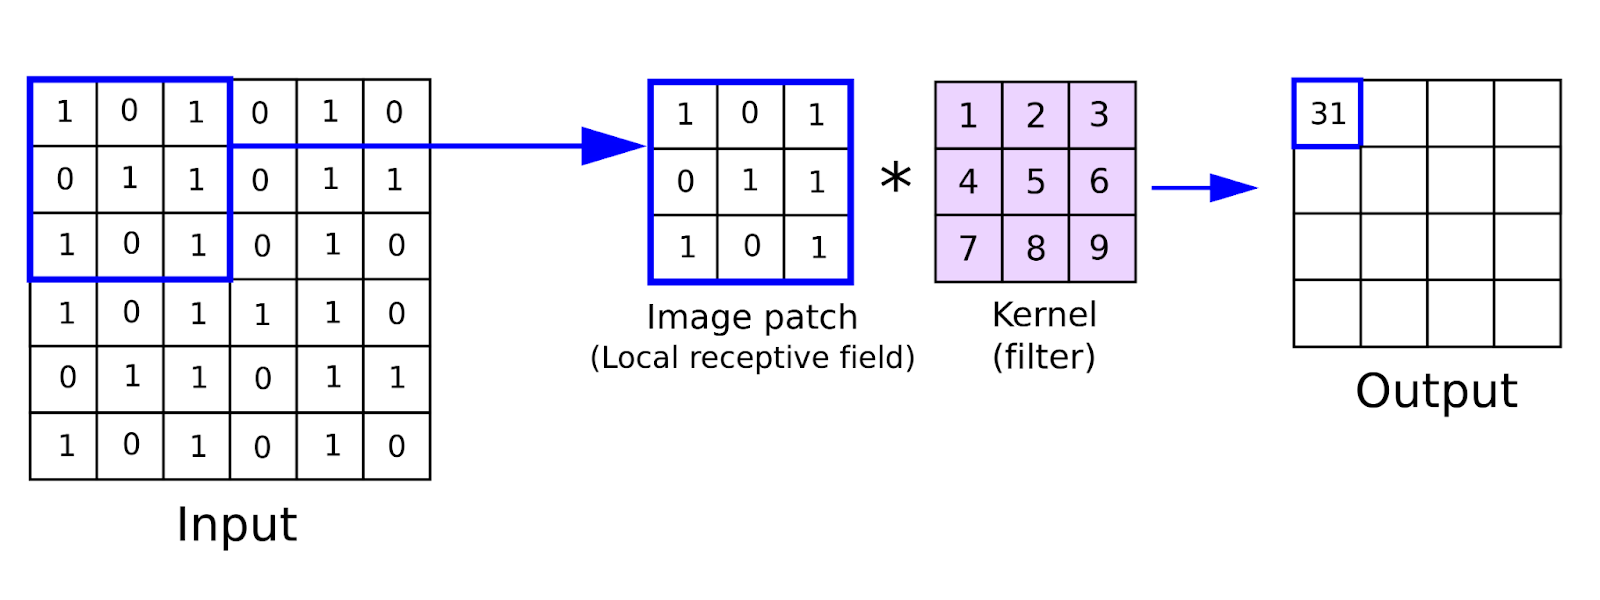

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [ ]:
# With square kernels and equal stride
conv = nn.Conv2d(in_channels=16, out_channels=33, kernel_size=3)
input = torch.randn(20, 16, 50, 100)
output = conv(input)
print(output.size())

torch.Size([20, 33, 48, 98])


Для простоты на занятии мы ограничимся линейными отображениями.

## <font color='green'>1.2.3 MLP</font>

Нет, речь о других "рабочих лошадках" Deep Learning :)

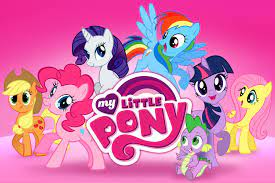

Мы поговорим о **<font color='red'> Multi-layer Perceptron</font>** 

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

**Q:** Разумно ли брать композицию двух линейных отображений? $$A \in \operatorname{Mat}_{m \times k}, \qquad B \in \operatorname{Mat}_{k \times n} $$

**A:** Нет, снова получатся линейные отображения (ранга не более $k$)  $$AB \in \operatorname{Mat}_{m \times n}.$$

**Вывод:** между линейными отображениями следует ставить нелинейность - какую-нибудь **<font color='blue'>функцию активации</font>**, например 

*   **Sigmoid** $$ {\displaystyle S(x)={\frac {1}{1+e^{-x}}}} : \mathbb{R} \to (0, 1)$$
*   **Hyperbolic tangent** $$ {\tanh x={\frac {e^{x}-e^{-x}}{e^{x}+e^{-x}}}}: \mathbb{R} \to (-1, 1)$$
*   **ReLU** $$ReLU(x) = \max(0,x) : \mathbb{R} \to \mathbb{R}_{\geq 0}$$







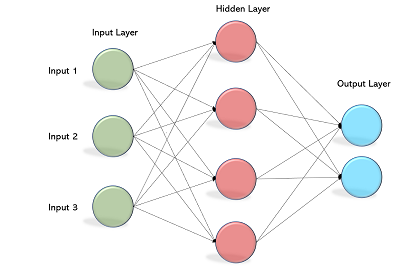

Простейшие нейронки, которых нам хватит для выполнения заданий  - **<font color='red'> MLP </font>** -  композиции 
*   линейных отображений (**<font color='blue'>полносвязных слоёв</font>**) и 
*   нелинейностей  (**<font color='blue'>функций активации</font>**): 
$$Linear \to Activation \to Linear \to Activation \to ...$$

На картинке выше стрелочки соответствуют линейным связям, а в каждом узле (кроме узлов на входе) "сидит функция активации".

По теореме Цыбенко (https://en.wikipedia.org/wiki/Universal_approximation_theorem) *MLP - универсальные аппроксиматоры*.

# <font color='green'>2. Препроцессинг данных</font>  

Мы рассмотрим ультра-стандратный датасет цифирек MNIST

Инструкция https://pytorch.org/vision/stable/datasets.html

Зададим **batch_size** (=сколько картинок будем брать за раз).

Каждую картинку сразу отобразим **преобразованием** (из transforms) в Torch Tensor.


In [ ]:
BATCH_SIZE = 32
transform = TF.ToTensor()

Загружаем датасет

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Чтобы подавать картики создадит объект класса **Dataloader**

Указываем:

*   Dataset откуда берётся данные
*   Batch_size = сколько картинок брать за раз
*   Shuffle = Нужно ли их перемешивать
*   Num_workers = сколько параллельных процессов создать (обычно число ядер у процессора) 

In [ ]:
dataloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Количество изображений в dataloader - команда len:

In [ ]:
len(dataloader)

1875

По dataloader можно итерироваться. Получим одно из отображений из MNIST

In [ ]:
for X, y in dataloader:
  print(X.shape, y.shape)
  print(y)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8])


Посмотрим на цифры

In [ ]:
from itertools import islice

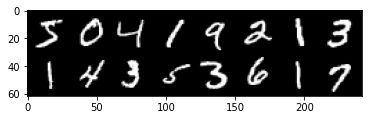

In [ ]:
images, _ = list(islice(dataloader, 1))[0]
plt.imshow(make_grid(images[:16], nrow=8).permute(1, 2, 0))
plt.show()

Точно также загрузим тестовый датасет

In [ ]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

При обучении мы будем несколько раз проходиться по одному и тому же датасету. 

Чтобы избежать переобучения картинку можно **аугментировать** - немного менять их. Например

*   Повертеть
*   Симметрично отразить
*   Изменить масштаб
*   Изменить цвета

и т.д. Нам это не понадобится, но обычно это очень полезно. Подробнее - см. https://pytorch.org/vision/stable/transforms.html




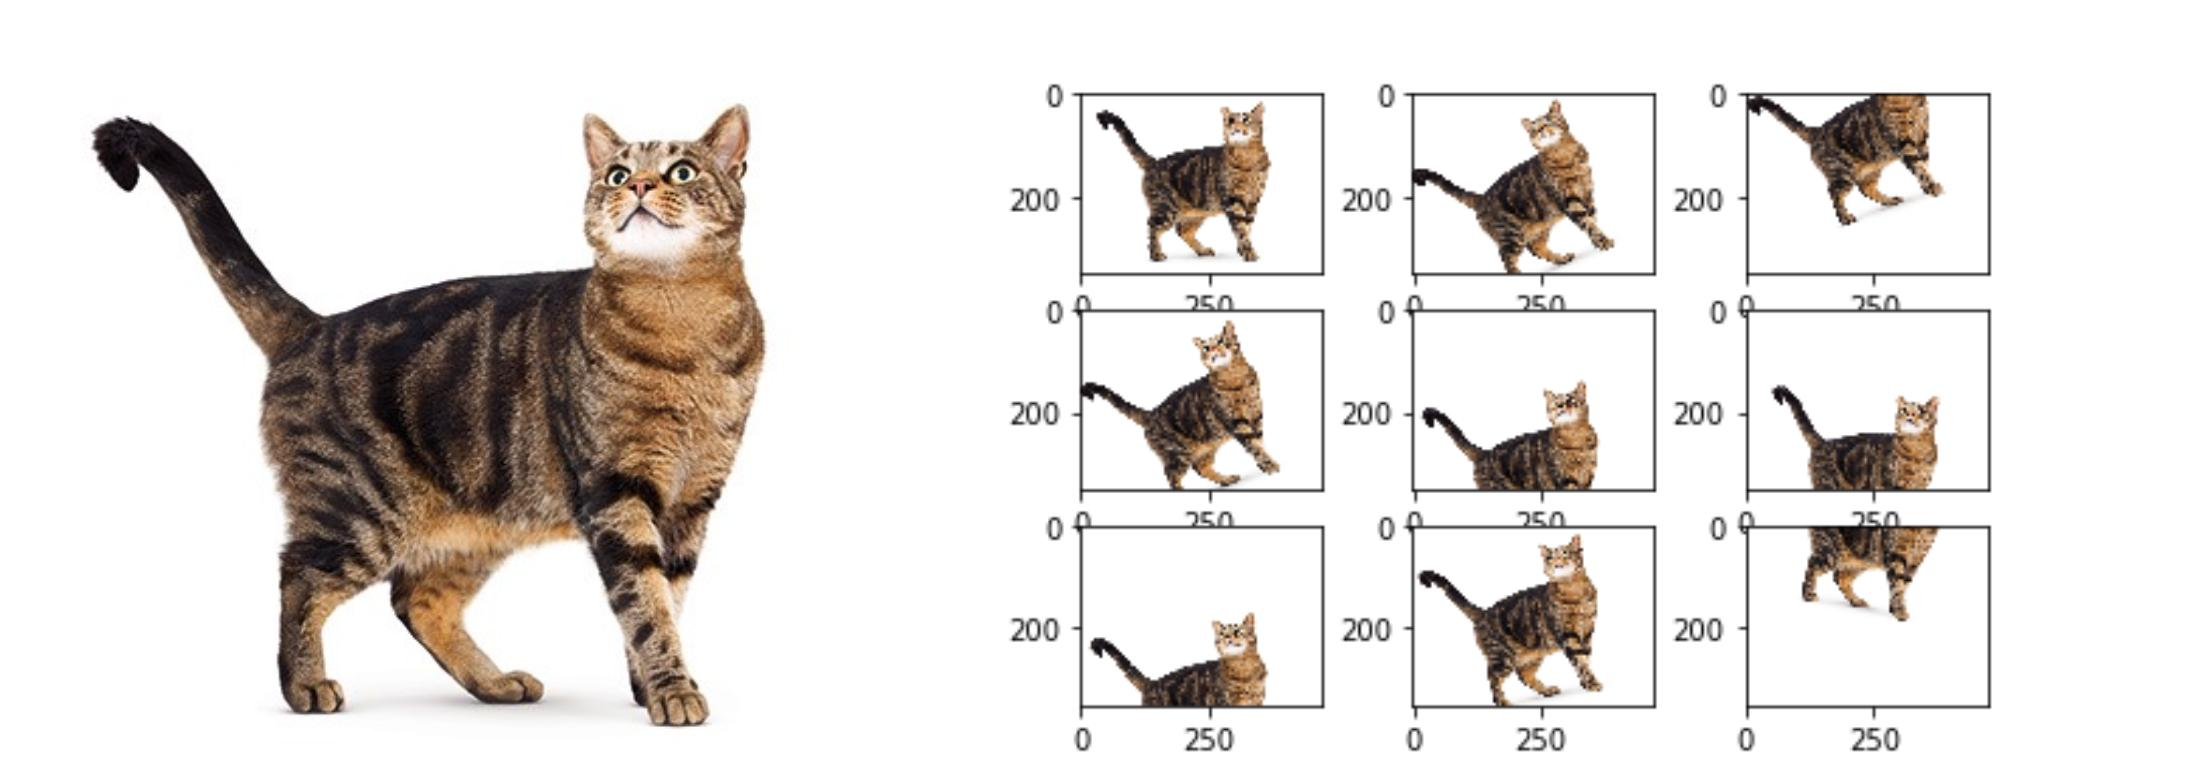

# <font color='green'>3.  Autoencoder</font>   


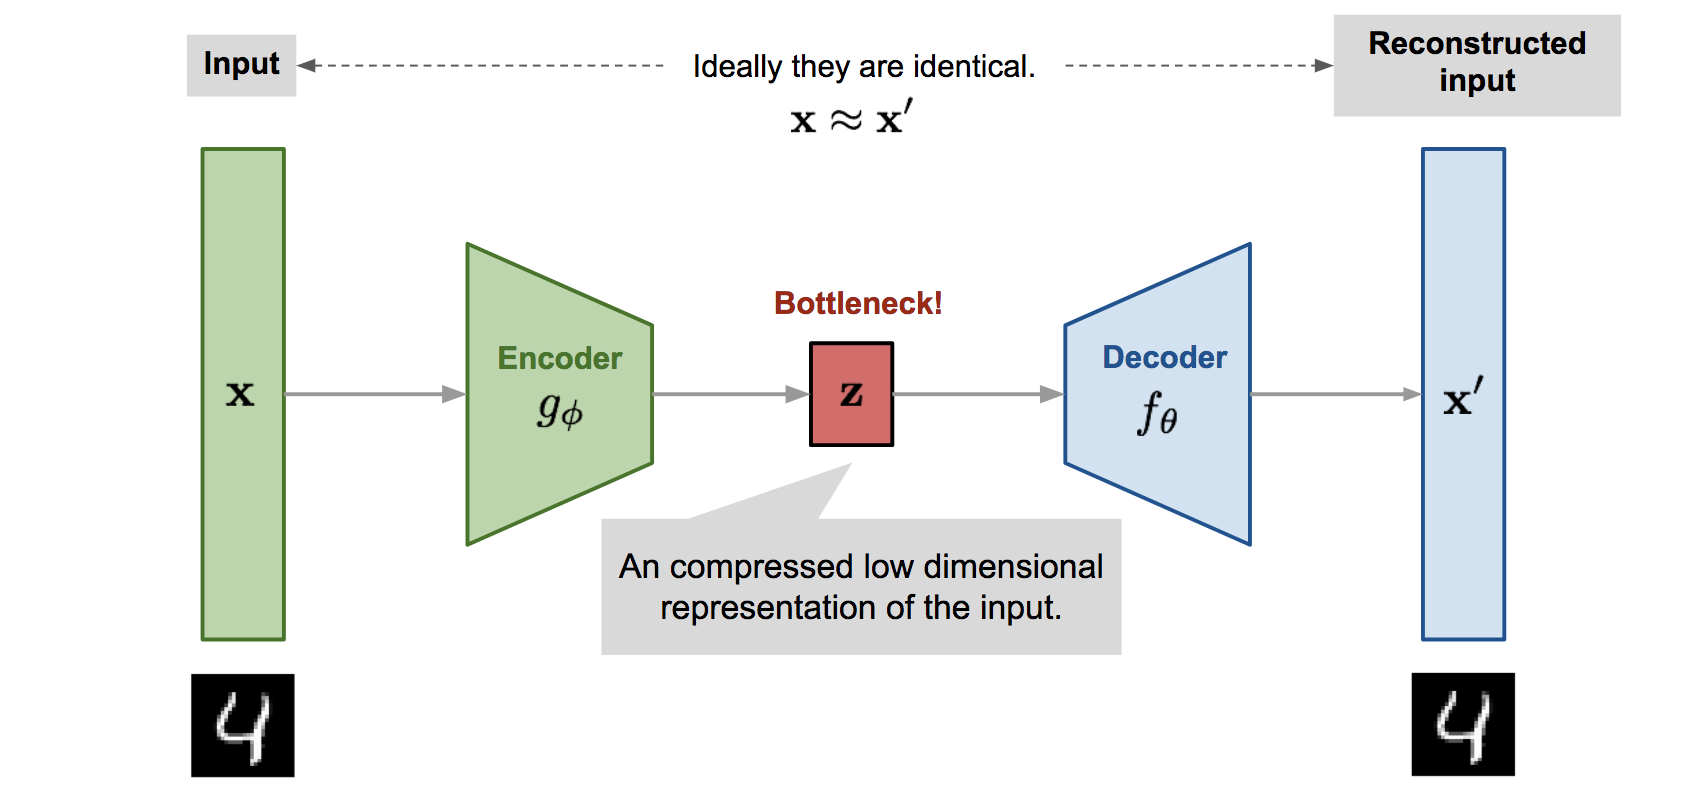

Точнее Энкодер и Декодер будут состоять из пары **линейных отображений**.

Композиция линейных отображений - снова линейное отображение. Поэтому их следует разделить нелинейной **функцией активации**.

В итоге энкодер и декодер будут следующими последовательностями отображений:
$$Encoder:  Linear \to ReLU \to Linear \to ReLU $$
$$Decoder:  Linear \to ReLU \to Linear \to Sigmoid$$

Слои в середине будут иметь размерность 128.

## <font color='green'>3.1 Создаём Autoencoder</font>   

Подробнее: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [ ]:
# Нейронная сеть наследуется из класса nn.Module
class Autoencoder(nn.Module):

    # Нужно задать функции __init__ и forward
    # В init обычно задаётся структура нейронной сети
    def __init__(self):
        super(Autoencoder,self).__init__()

        # Размер слоёв "в середине" будет 128
        self.hid_size_ = 128
        
        # Последовательность отображений задаётся командой nn.Sequential
        # Энкодер
        self.encoder = nn.Sequential( 
            nn.Linear(28*28, self.hid_size_),
            nn.ReLU(), 
            # Вставляем функцию активации между линейными отображениями 
            # ReLU(x) = 1, x>0 и = 0 иначе
            nn.Linear(self.hid_size_, self.hid_size_),
            nn.ReLU())

        # Декодер
        self.decoder = nn.Sequential(  
            nn.Linear(self.hid_size_, self.hid_size_),
            nn.ReLU(),
            nn.Linear(self.hid_size_, 28*28),
            nn.Sigmoid()) # В конце нужны пиксели от 0 до 1

    # Функция forward принимает батч объектов 
    # и вычисление их образ под действием нейронной сети
    def forward(self,x):
        x = nn.Flatten()(x) # shape = (N, 1*28*28)
        z = self.encoder(x) # латентное представление

        y = self.decoder(z)
        y = torch.reshape(y,(-1, 1,28,28)) # тензор (N, 28*28) -> картинки (N, 1, 28, 28)
        return y, z

Посмотрим на наши модели. Рассмотрим образ 2ух изображений под действием АвтоЭнкодера

In [ ]:
ae = Autoencoder()
ae.to(device)
# img size is (1, 28, 28)
img = torch.rand((2, 1, 28, 28)).to(device)
reconstruction, latent = ae(img)
print(reconstruction.shape, latent.shape)

torch.Size([2, 1, 28, 28]) torch.Size([2, 128])


## <font color='green'>3.1.1 Удобное описание нейронных сетей </font>    

In [ ]:
from torchsummary import summary

Энкодер

In [ ]:
encoder =  Autoencoder().encoder
encoder.to(device)
summary(encoder,  tuple([28*28])) # image size is (1, 28, 28)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
Total params: 116,992
Trainable params: 116,992
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.45
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


In [ ]:
decoder =  Autoencoder().decoder
decoder.to(device)
summary(decoder, tuple([128]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          16,512
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 784]         101,136
           Sigmoid-4                  [-1, 784]               0
Total params: 117,648
Trainable params: 117,648
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


# <font color='green'>4. Обучаем нейронную сеть</font>  

Создадим нейронную сеть. Сразу поместим её на нужный device

In [ ]:
autoencoder = Autoencoder().to(device)

Выбираем лосс. В данном случае возьмём MSE

https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

In [ ]:
criterion = nn.MSELoss() # По традиции лосс называют criterion

Выбираем **optimizer** - способ, по которому обновляются веса (есть разные модификации градиентного спуска)

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

Самый важный параметр - величина шага при градиентном спуске (learning rate)

In [ ]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

Остаётся выбрать:

*   сколько раз мы проходимся по датасету (число **эпох**)
 
Отметим, что размер **батча** (сколько картинок берётся за раз) мы выбрали выше.

In [ ]:
num_epochs = 5

Загрузим пару моделуй для визуализации процесса обучения

In [ ]:
from IPython import display
from IPython.display import clear_output
from tqdm.auto import tqdm # для вывода на экран прогресса обучения

##  <font color='green'>4.1 Функция для обучения нейронной сети</font>  


In [ ]:
def train(model, optimizer, loader, criterion):
    # У модели можно заморозить градиенты командой model.eval()
    # Команда model.train() размораживает их 
    model.train()
    # Массив потерь на каждой эпохе обучения
    losses_tr = []

    # Загружаем батчи из dataloader
    for iteration, (batch, _) in tqdm(enumerate(loader)):
        # batch и нейронная сеть должны быть на одном device
        batch = batch.to(device)
        
        ### Градиентный спуск ###
        # На каждом шаге нужно обнулить градиенты optimizer 
        # Если сеть сложная и у неё много выходов, то градиенты нужно запоминать и складывать
        # У нас простая сеть с одним выходом
        optimizer.zero_grad()

        # Применяем нейронную сеть
        reconstruction, latent_code = autoencoder(batch)
        
        # Вычисляем лосс
        loss = criterion(batch, reconstruction)

        # Эта команда вычисляет градиенты
        loss.backward()
        # Обновляем веса при помощи optimizer
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

##  <font color='green'>4.2 Функция для валидации </font>  

In [ ]:
def val(model, loader, criterion):
    # Главный нюанс - на тестовом датасете мы не учимся (!)
    # Градиенты не должны обновляться. Поэтому  model.eval() 
    model.eval()
    losses_val = []
    # При обучении лоссу не нужно считать градиенты, тратить на это время
    # "with torch.no_grad()" - спелл, чтобы не считались градиенты
    with torch.no_grad():
        # Схема аналогична train, но без обновления градентов  
        for iteration, (batch, _) in tqdm(enumerate(loader)):
          batch = batch.to(device)
          reconstruction, latent_code = model(batch)
          loss = criterion(batch, reconstruction)
          losses_val.append(loss.item()) 
    return np.mean(losses_val)

##  <font color='green'>4.3 Обучение по эпохам </font>  

In [ ]:
def learning_loop(model, optimizer, train_loader, val_loader, criterion, epochs=10, 
                  # Параметры для валидации и рисования
                  val_every=1, draw_every=1, separate_show=False):
  
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        # Обучаем модель
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        # Сохраняем лосс
        losses['train'].append(loss)
        
        # Валидируем и сохраняем лосс каждые val_every эпох
        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)

        ### НИЖЕ РИСОВАНИЕ ###
        # Рисуем график каждые draw_every шагов
        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
    return model, optimizer, losses

##  <font color='green'>4.4 Training montage</font>  

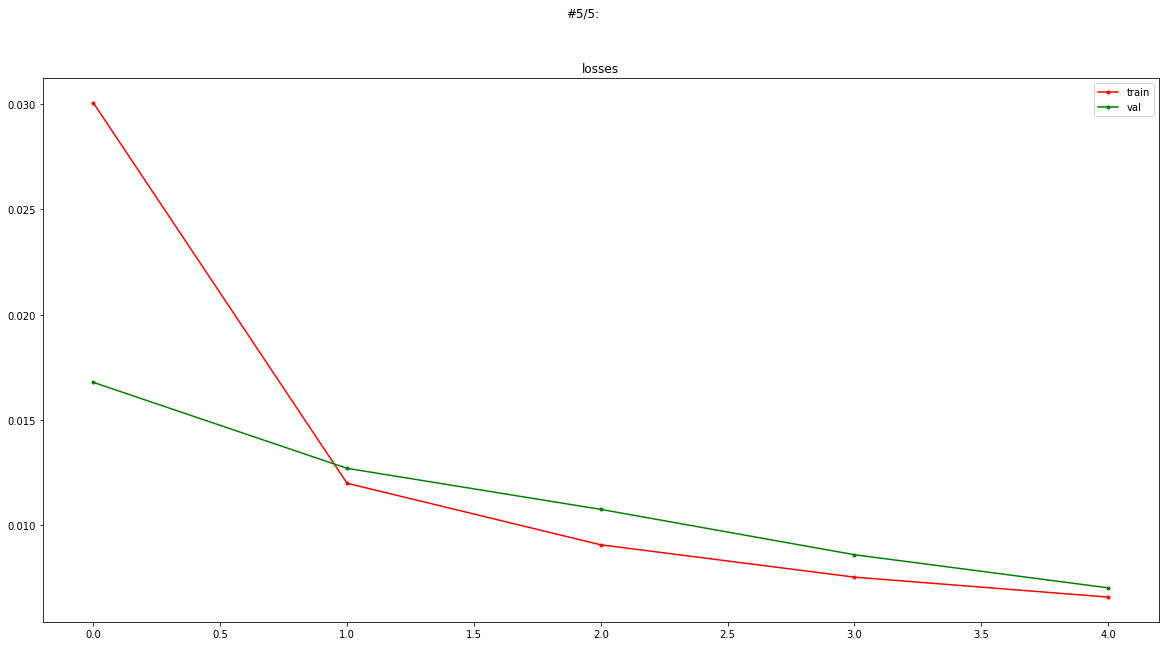

In [ ]:
autoencoder, optimizer, losses = learning_loop(
    model = autoencoder,
    optimizer = optimizer,
    train_loader = dataloader,
    val_loader = testloader,
    criterion =  criterion,
    epochs = num_epochs,
  )

*Обучаться можно, пока лосс на валидации не стабилизируется* **= не будет падать на последних нескольких эпохах**. 

Для простоты можно обучать **несколько десятков эпох (20-100) эпох**. 

# <font color='green'>5. Посмотрим на результат</font> 

In [ ]:
from itertools import islice

Загрузим серию картинок

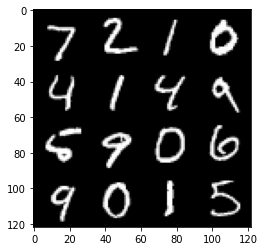

In [ ]:
images, _ = list(islice(testloader, 1))[0]
plt.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
plt.show()

Применим автоэнкодер

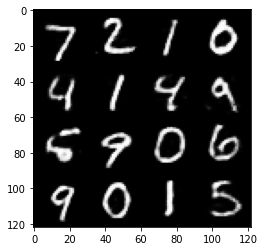

In [ ]:
reconstruction, latent_code = autoencoder(images.to(device))
reconstruction = reconstruction.cpu()
plt.imshow(make_grid(reconstruction[:16], nrow=4).permute(1, 2, 0))
plt.show()

Могло быть хуже)

# <font color='green'>6. Сэмплирование </font> 

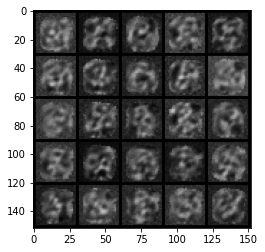

In [ ]:
z = torch.randn(25, 128) * 0.5
reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1)
plt.imshow(make_grid(reconstruction.cpu().reshape(-1, 1, 28, 28), nrow=5).permute(1, 2, 0))
plt.show()

Видно, что генерация AE плохая.

### <font color='red'>Латентное представление AE не предназначено для генерации. </font> 